# Case Study 3 workout
The actual coding of the optimization

## Mapping of Cartesian Grid to cs3 Boundary

### Read in boundary and select vertex points
`1015.22.Nov.19`

For area 3a (the only portion used in cs3), verticies were selected as the four "corners". I forsee the upper boundary giving the greatest difficulty.
<img src="figures/cs3boundaryvertices.png" alt="cs3 boundary with example turbine placement" width="400"/>
I'll attempt with the right side boundary first (circled in green) since it's relatively simple.
1. Make points along the arclength
2. Spline the points
3. (test) one segment to the left, to make sure it follows generally the curve.

In [2]:
#-- Necessary Headers --#
from __future__ import print_function   # For Python 3 compatibility
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
import sys
import yaml                             # For reading .yaml files
from math import radians as DegToRad    # For converting degrees to radians
from math import log as ln              # For natural logrithm

# Structured datatype for holding coordinate pair
coordinate = np.dtype([('x', 'f8'), ('y', 'f8')])

In [3]:
#-- Helper Functions --#
def getTurbAtrbt3aYAML(file_name):   # Read in boundary (originally written in MATLAB, needed to be translated)
    '''Retreive boundary coordinates from the <.yaml> file'''
    # Read in the .yaml file
    with open(file_name, 'r') as f:
        ptList = yaml.safe_load(f)['boundaries']['IIIa']

    # (Convert from <list> to <coordinate> array)
    numCoords = len(ptList)                         # Determine how many points we have for the boundary
    coordList = np.recarray(numCoords, coordinate)  # Initialize the point list array 
    for i in range(numCoords):
        coordList[i].x = float(ptList[i][0])
        coordList[i].y = float(ptList[i][1])

    return coordList

In [4]:
#- Rip the boundary coordinates from the .yaml file -#
fn = "iea37-boundary-cs3.yaml"
bndryPts = getTurbAtrbt3aYAML(fn)
print(bndryPts)

[(10363.8, 6490.3) ( 9449.7, 1602.2) ( 9387. , 1056.6) ( 9365.1,  625.5)
 ( 9360.8,  360.2) ( 9361.5,  126.9) ( 9361.3,  137.1) ( 7997.6, 1457.9)
 ( 6098.3, 3297.5) ( 8450.3, 6455.3) ( 8505.4, 6422.3) ( 9133. , 6127.4)
 ( 9332.8, 6072.6) ( 9544.2, 6087.1) ( 9739. , 6171.2) ( 9894.9, 6316.9)
 (10071.8, 6552.5) (10106.9, 6611.1)]


In [5]:
#- Hard code the vertex selection -#
vertexList = [0, 6, 8, 9] # top right, bottom right, bottom left, top left

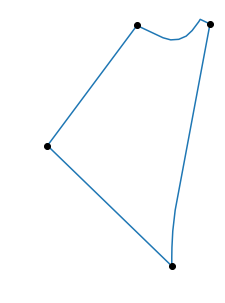

In [13]:
#- Code for visualizing farm area -#
def closeBndryList(bndryPts):
    # Appends the first element to the end of an <np.ndarray> of type <coordinate> for closed boundary #
    numCoords = len(bndryPts)                           # Determine how many points we have for the boundary
    coordList = np.recarray((numCoords+1), coordinate)  # Initialize the point list array 
    for i in range(numCoords):
        coordList[i].x = float(bndryPts[i].x)
        coordList[i].y = float(bndryPts[i].y)

    coordList[i+1].x = bndryPts[0].x
    coordList[i+1].y = bndryPts[0].y
    
    return coordList

def printBoundary(bndryPts, size):
    #-- Print the windfarm boundary. bndryPts must be <np.ndarray> of type <coordinate>    
    plt.plot(bndryPts.x, bndryPts.y)
    #plt.xlim(coordList.x.min(), coordList.x.max()) # scales the x-axis to only include the boundary
    plt.axis('scaled')                      # Trim the white space
    plt.axis('off')                         # Turn off the framing
    plt.gcf().set_size_inches(size.x, size.y)   # Make it big and readable
    
def printBoundaryArray(bndryPtsX, bndryPtsY, size):
    #-- Print the windfarm boundary. bndryPts must be <np.ndarray> of type <coordinate>    
    plt.plot(bndryPtsX, bndryPtsY)
    plt.axis('scaled')                      # Trim the white space
    plt.axis('off')                         # Turn off the framing
    plt.gcf().set_size_inches(size.x, size.y)   # Make it big and readable


def printVerticies(coordList, vertList, colorName):
    plt.hold = True
    plt.plot(coordList[vertList].x, coordList[vertList].y,'o', color = colorName)
    
coordList = closeBndryList(bndryPts)    # Duplicate the first coordinate for a closed boundary
displaySize = np.recarray(1, coordinate)
displaySize.x = 6
displaySize.y = 5
printBoundary(coordList,displaySize)
printVerticies(coordList, vertexList, 'black')
#plt.savefig("./figures/cs3corners.pdf")
plt.show()

### Making the arclength partitions
`1304.22.Nov.19`

The segment we're looking at:


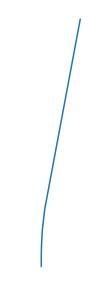

In [14]:
#-- Pull right side, all points between indicies 0 and 6 --#
rsBndry = bndryPts[vertexList[0]:vertexList[1]]
print("The segment we're looking at:")
displaySize.y = 5
printBoundary(rsBndry, displaySize) # for debug

def coordDist(pt0, pt1):
    # Returns the euclidean distance between two <coordinate> points
    xDiff = pt0.x - pt1.x
    yDiff = pt0.y - pt1.y
    return np.sqrt(xDiff**2 + yDiff**2)

def getArcLength(coordList):
    # Returns the total distance of a given <np.ndarray> of <coordinate> type
    numCoordPairs = len(coordList)-1
    totDist = 0                   # Initialize to zero
    for i in range(numCoordPairs): # Go through all the point pairs
        totDist = totDist + coordDist(coordList[i], coordList[i+1])

    return totDist

In [15]:
# Test that arclength function is working
print("Check: We expect arclength to be slightly longer")
print("Total arc length:", getArcLength(rsBndry))
print("1st to last pt length:",coordDist(bndryPts[0], bndryPts[6]))

Check: We expect arclength to be slightly longer
Total arc length: 6452.318959803356
1st to last pt length: 6431.808181996723


In [16]:
def findNewPtOnLine(pt0,pt1,dist):
    # Given (x0,y0) and (x1,y1), finds (x2,y2) a distance dist from (x0,y0)
    # along line defined by (x0,y0) and (x1,y1).
    # https://math.stackexchange.com/questions/175896/finding-a-point-along-a-line-a-certain-distance-away-from-another-point
    newPt = np.recarray(1, coordinate)
    distTot = abs(coordDist(pt0,pt1))
    t = dist/distTot;
    newPt.x = ((1-t)*pt0.x) + t*pt1.x;
    newPt.y = ((1-t)*pt0.y) + t*pt1.y;
    
    return newPt

def sliceBoundary(totCoordList, numDivs):
    # Given a set of <coordinate> on a line (or boundary), and number of divisions,
    # This will return a set of pts that have sliced that line <numDivs> many times.
    # TERMINOLOGY: 'Segment' slice of boundary line, 'Leg' means portion of boundary we're on
    tol = 1e-6  # Tolerance for reaching the end of the line
    segCoordList = np.recarray(numDivs+1, coordinate)  # Initialize slice list (extra spot for starting point)
    rsArcLen = getArcLength(totCoordList)    # Get total edge length
    rsSegmentLen = rsArcLen/numDivs          # The length of each subdivided segment.

    # Traverse along the edge, marking where a segment ends
    distNeeded = rsSegmentLen # Distance remaining till next marker
    distRemain = distNeeded   # Distance remaining until segment ends
    segCoordList[0] = totCoordList[0] # Don't forget the first point.
    cntrLeg = 0               # Start at the first leg
    #-- Traverse and place --#
    leftPt = totCoordList[0]
    rightPt = totCoordList[1]
    distRemLeg = abs(coordDist(leftPt, rightPt))
    # Loop through all portions, marking as we go
    for cntrSeg in range(numDivs):
        while(distRemLeg < distRemain):             # If the remainder of our segment is smaller than we need
            if (abs(distRemain - distRemLeg) > tol):
                distRemain = distRemain - distRemLeg    # Take out that much distance
                cntrLeg = cntrLeg + 1                   # Move to the next leg
                leftPt = totCoordList[cntrLeg]          # Move our left point
                rightPt = totCoordList[cntrLeg+1]
                distRemLeg = abs(coordDist(leftPt, rightPt))
            else:                                       # If rounding error makes us go past our line
                break

        segCoordList[cntrSeg+1] = findNewPtOnLine(leftPt,rightPt,distRemain)
        leftPt = segCoordList[cntrSeg+1]
        distRemLeg = distRemLeg - distRemain;       # Take out how much we used
        distRemain = distNeeded;                    # Reset how much we need

    return segCoordList

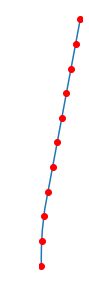

In [17]:
#---- Visualize with 10 slices ----#
displaySize.y = 5
numDivs = 10# Arbitrary, but we'll go with 100 slices.
rightBndrySegCoords = sliceBoundary(rsBndry, numDivs)

printBoundary(rsBndry, displaySize)
printVerticies(rightBndrySegCoords, list(range(numDivs+1)), 'red')

### Spline the boundaries
`1805.22.Nov.19`

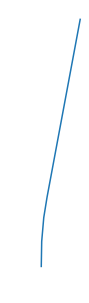

In [18]:
#- Spline the right side -#
rsSpline = interp1d(rightBndrySegCoords.x, rightBndrySegCoords.y, kind='linear')
xnew = np.linspace(rightBndrySegCoords[0].x, rightBndrySegCoords[len(rightBndrySegCoords)-1].x, num=1000, endpoint=True)

printBoundaryArray(xnew, rsSpline(xnew), displaySize)

In [19]:
displaySize.y = 10
numDivs = 20
clsdBP = closeBndryList(bndryPts)
vertexList = [0, 6, 8, 9, 18]

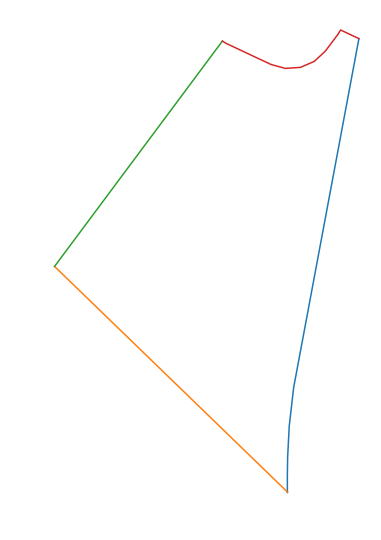

In [20]:
#-- Plot all the sides (no splines for comparison) --#
for i in range(len(vertexList)-1):
    BndPts = clsdBP[vertexList[i]:(vertexList[i+1]+1)]
    plt.hold = True
    printBoundary(BndPts, displaySize) # for debug
    
plt.savefig("./figures/cs3splines.pdf")

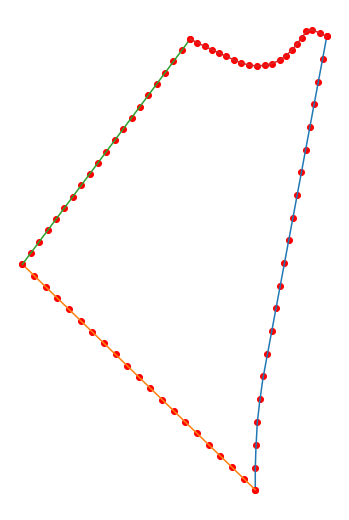

In [13]:
#-- Plot all the sides (with splines) --#
for i in range(len(vertexList)-1):
    BndPts = clsdBP[vertexList[i]:(vertexList[i+1]+1)]
    BndrySegCoords = sliceBoundary(BndPts, numDivs)
    #printVerticies(BndrySegCoords, list(range(numDivs+1)), 'red')
    Spline = interp1d(BndrySegCoords.x, BndrySegCoords.y, kind='linear')
    xnew = np.linspace(BndrySegCoords[0].x, BndrySegCoords[len(BndrySegCoords)-1].x, num=1000, endpoint=True)
    plt.hold = True
    printBoundaryArray(xnew, Spline(xnew), displaySize)

# Continued
in bakerIEA37cs3-03-cs3workout

This is where I'll need to compare to [Eduardo's](https://github.com/byuflowlab/wind-farm-utilities/blob/master/docs/geometry_processing.ipynb) method.

I'm thinking I'll do 50 divisions per side, just to visualize. I'll have to experiment with getting the grids to look right.

Also, don't forget to save the calculated lines (with correct endpoints) from the previous section.